Need to show two solutions are unstable since they do not occur in simulations.

In [3]:
from functions import Plasma, Spectral, polyeig
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import lambertw
from tqdm import tqdm
from scipy.optimize import curve_fit

W = lambda z,k: np.real(lambertw(z,k=k)) # I only need the real parts

In [4]:
def velocity_profile(M, Mm, x, constant_velocity=False,acclerting=True):
    if constant_velocity:
        v = Mm*np.ones_like(x) # constant v=0.1
        return v

    if Mm < 1:
        v = M(x, Mm=Mm, k=0) # subsonic velocity profile, M_m = 0.1
    elif Mm == 1:
        if method == "FD":
            if acclerting:
                v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=-1)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x<0], Mm=1, k=-1), [1], M(x[x>0], Mm=1, k=0)]) # decelerating velocity profile
                #v = np.concatenate([M(x[x<0], Mm=1, k=0), [1], M(x[x>0], Mm=1, k=0)])
        elif method == "CH":
            if acclerting:
                v = np.concatenate([M(x[x>0], Mm=1, k=-1), M(x[x<0], Mm=1, k=0)]) # accelerating velocity profile
            else:
                v = np.concatenate([M(x[x>0], Mm=1, k=0), M(x[x<0], Mm=1, k=-1)]) # decelerating velocity profile
    else:
        v = M(x, Mm=Mm, k=-1) # supersonic velocity profile
    return v

In [29]:
# domain information
N = 101 # 200 cells
domain = "symmetric"
method = "CH"
spectral = Spectral(N,domain,method)

# magnetic field, B, and velocity profile, M
B0 = 1
R = 0.5
Bm = 1+R
Delta = 0.1/0.3
B = lambda z: B0*(1+R*np.exp(-(z/Delta)**2))

# k=-1: supersonic branch
# k=0: subsonic branch
M = lambda z, Mm, k: np.sqrt( -W(-Mm**2 * (B(z)/Bm)**2 * np.exp(-Mm**2), k=k) )

E0 = 1 # unit: V/m
B0 = 1 # unit: G
Ln = -0.3 # density gradient
LE = 0.004 # shear scale
Lb = 0 # magnetic field gradient
n = 1e16 # density m^{-3}
Te = 10 # electron temperature in eV
Ti = 0 # ion temperature in eV
fluid = 'Ar' # fluid type
plasma = Plasma(n,Te,Ti,Ln,Lb,E0,B0,fluid)

x = spectral.x
Mm = 0.5
acclerting = False
constant_velocity = True
plasma.v = velocity_profile(M,Mm,x,constant_velocity,acclerting)

In [30]:
# Eq.(9) and (10) in note

# D = spectral.D1
# I = np.eye(*D.shape)
# v = plasma.v
# A11 = 0.5*D@v/v*(1-v)*I - np.diag(v+1)@D 
# A12 = -0.5*D@v/v*(1-v)*I
# A21 = 0.5*D@v/v*(1+v)*I
# A22 = -0.5*D@v/v*(1+v)*I - np.diag(v-1)@D 
# A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
# e,Y = np.linalg.eig(A)

# Yplus = Y[:N-2,:]
# Yminus = Y[N-2:,:]
# V = (Yplus-Yminus)/2
# V = np.pad(V, ((1,1),(0,0)), 'constant', constant_values=0)
# n = (Yplus+Yminus)/2
# omega = -1j*e 


# split the polynomial eigenvalue problem into matrix
D1 = spectral.D1
D2 = spectral.D2
I = np.eye(*D1.shape)
v0 = plasma.v 
A11 = np.zeros_like(D1)
A12 = I
A21 = np.diag(1-v0**2)@D2 \
        - np.diag((3*v0 + 1/v0)*(D1@v0))@D1 \
        - np.diag((1-1/v0**2)*(D1@v0)**2) \
        - np.diag((v0+1/v0)*(D2@v0))
A22 = 2*(np.diag(v0)@D1 + np.diag(D1@v0))

A = np.block([[A11[1:-1,1:-1], A12[1:-1,1:-1]],[A21[1:-1,1:-1], A22[1:-1,1:-1]]])
e,V = np.linalg.eig(A)

omega = -1j*e
V = V[:spectral.x.size-2,:]
V = np.pad(V, ((1,1),(0,0)), 'constant', constant_values=0)

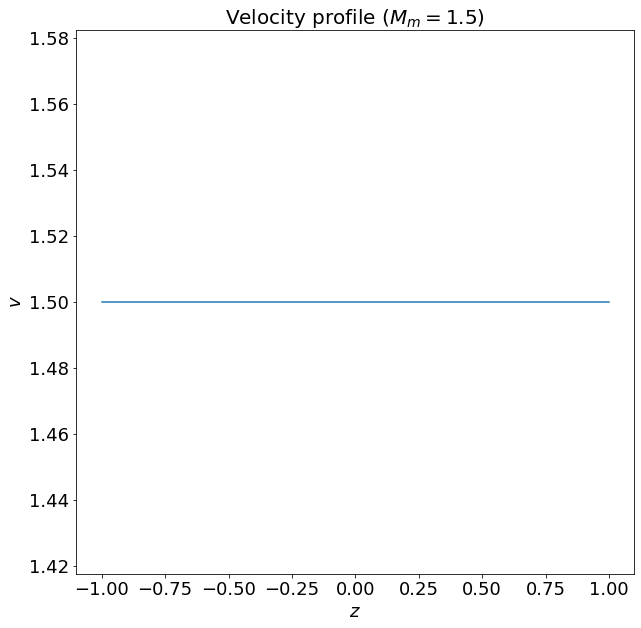

In [25]:
# velocity profile

plt.figure()
plt.plot(spectral.x, plasma.v)
plt.title(f"Velocity profile ($M_m={Mm}$)")
plt.xlabel("$z$")
plt.ylabel("$v$");

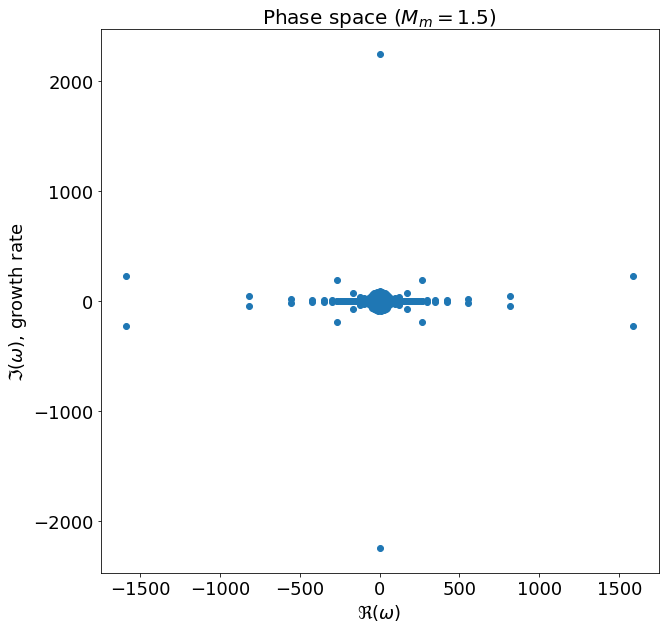

In [26]:
# phase space
plt.figure()
selection = (np.abs(np.real(omega))<10) & (np.abs(np.imag(omega))<10)
omega_ = omega#[selection]

plt.plot(np.real(omega_), np.imag(omega_), 'o')
plt.xlabel("$\Re(\omega)$")
plt.ylabel("$\Im(\omega)$, growth rate")
if (Mm == 1) & (acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, accelerating)");
elif (Mm == 1) & (not acclerting):
    plt.title(f"Phase space ($M_m={Mm}$, decelerating)");
else:
    plt.title(f"Phase space ($M_m={Mm}$)");

/tmp/ipykernel_20506/4178394849.py:16: RuntimeWarning: invalid value encountered in true_divide
  v_imag = np.imag(v)/np.abs(np.imag(v)).max()
/tmp/ipykernel_20506/4178394849.py:16: RuntimeWarning: invalid value encountered in true_divide
  v_imag = np.imag(v)/np.abs(np.imag(v)).max()
/tmp/ipykernel_20506/4178394849.py:16: RuntimeWarning: invalid value encountered in true_divide
  v_imag = np.imag(v)/np.abs(np.imag(v)).max()
/tmp/ipykernel_20506/4178394849.py:16: RuntimeWarning: invalid value encountered in true_divide
  v_imag = np.imag(v)/np.abs(np.imag(v)).max()


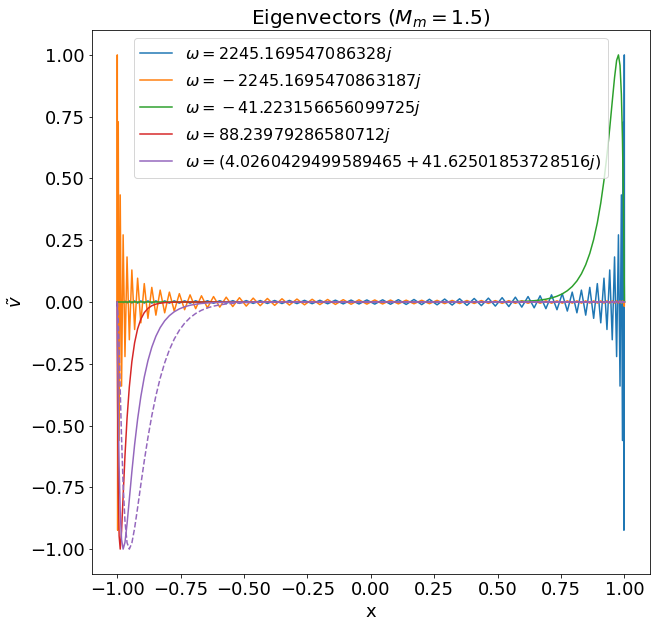

In [27]:
# eigenvectors
plt.figure()
#selection = (np.real(omega)>=0) & (np.abs(np.imag(omega))<5) 
selection = (np.real(omega) >=0)  & (np.abs(np.imag(omega))>5) 
omega_ = omega[selection]
V_ = V[:, selection]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
V_ = V_[:,ind]

size = 1 if omega_.size > 5 else omega_.size
for i in range(5):
    v = V_[:,i]
    v_real = np.real(v)/np.abs(np.real(v)).max()
    v_imag = np.imag(v)/np.abs(np.imag(v)).max()
    lines = plt.plot(spectral.x, v_real, label=f"$\omega={omega_[i]}$")
    plt.plot(spectral.x, v_imag, '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($M_m={Mm}$)")
plt.legend();

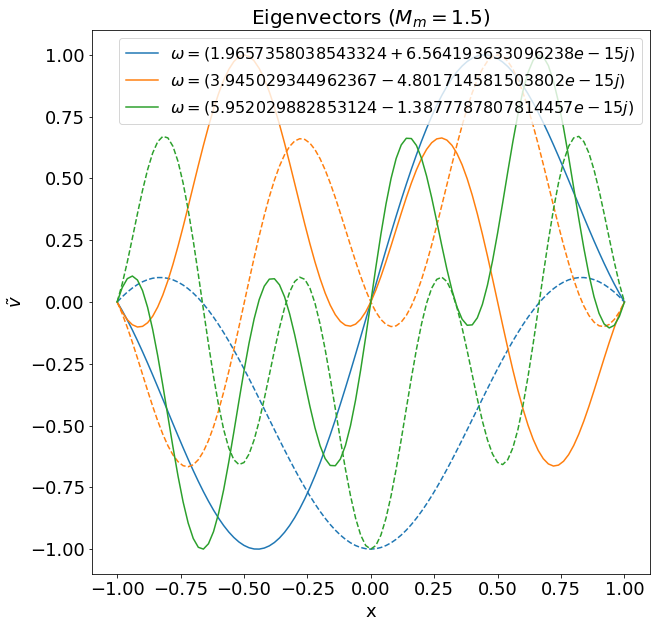

In [10]:
# eigenvectors
plt.figure()
selection = (np.real(omega)>=0) & (np.abs(np.imag(omega))<5) 
omega_ = omega[selection]
V_ = V[:, selection]

ind = np.argsort(np.abs(np.real(omega_)))
omega_ = omega_[ind]
V_ = V_[:,ind]

size = 1 if omega_.size > 5 else omega_.size
for i in range(3):
    v = V_[:,i]
    v_real = np.real(v)/np.abs(np.real(v)).max()
    v_imag = np.imag(v)/np.abs(np.imag(v)).max()
    lines = plt.plot(spectral.x, v_real, label=f"$\omega={omega_[i]}$")
    plt.plot(spectral.x, v_imag, '--', color=lines[0]._color)
plt.xlabel("x")
plt.ylabel("$\\tilde{v}$")
plt.title(f"Eigenvectors ($M_m={Mm}$)")
plt.legend();

Text(0.5, 1.0, 'Exact eigenvectors ($M_m=1.5$)')

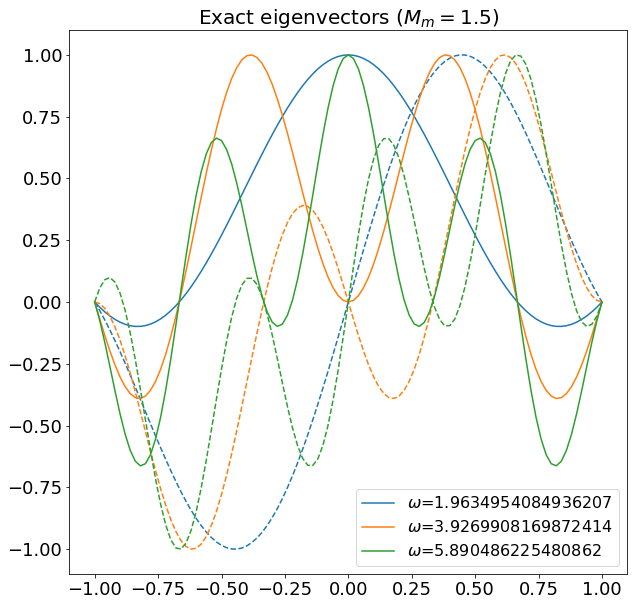

In [11]:
Omega_exact = -1j*np.arange(1,100)*np.pi*(1-v0[0]**2)/2
for i in range(3):
    a = Omega_exact[i]
    b = v0[0]
    x = spectral.x
    v_exact = np.exp(-a/(b+1))*( np.exp(a*(x+1)/(b+1)) - np.exp(a*(x+1)/(b-1)) )
    v_real = np.real(v_exact)/np.abs(np.real(v_exact)).max()
    v_imag = np.imag(v_exact)/np.abs(np.imag(v_exact)).max()
    lines = plt.plot(x, v_real, label=f"$\\omega$={np.real(-1j*a)}")
    plt.plot(x, v_imag, "--", color=lines[0]._color)
plt.legend()
plt.title(f"Exact eigenvectors ($M_m={Mm}$)")